The goal of this project is it, to create a model which in the end can be used in a website predicting the images captured by the webcam of the user and label these to one of the three classes rock, paper or scissors.

This project is split into two parts: First the creation of a Keras image classification model,  and the second part is the creation of a prototype website with usage of the created model.

### Part 1:

## Creation of Rock, Paper, Scissors Model with Keras

In this notebook we create an **image classification model with Keras**, predicting images of hands, if they show a rock, paper or scissors.
For this, we use the labelled Rock Paper Scissors dataset from Laurence Moroney which contains with CGI created images of hands from different races, ages and genders posing either rock, paper or scissors. (Source: https://laurencemoroney.com/datasets.html)

There is a training and a test set. 
You will need to have a folder "**data**" next to this file where you put these both downloaded unzipped folders *rps* and *rps-test-set*.

First, we want to take a look at the data. 
Therefore, the paths of the directories of the different classes are saved.

In [1]:
import os

rock_dir = os.path.join('data/rps/rock')
paper_dir = os.path.join('data/rps/paper')
scissors_dir = os.path.join('data/rps/scissors')

Then, a list of every filename of each class is saved. 

In [2]:
print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

total training rock images: 840
total training paper images: 840
total training scissors images: 840


For showcase, two pictures of each class are shown below by using matplotlib.

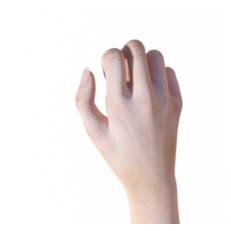

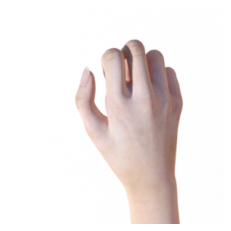

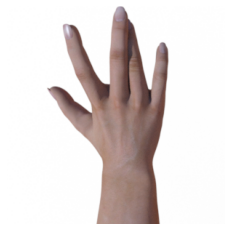

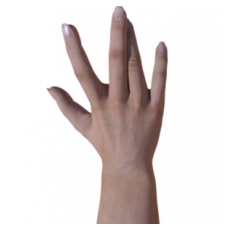

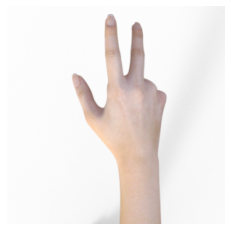

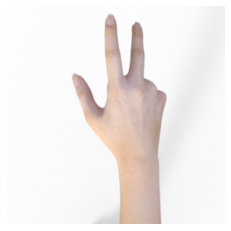

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

Now we will use real-time data augmentation with the help of `ImageDataGenerator` and `flow_from_directory` to generate batches of tensor images for training data and validation data.

In the ImageDataGenerator, many parameters can be set to manipulate the images. Images are rotated, horizontal flipped, rescaled and more.

The finished generated sets of data are saved as variablea *train_generator* and *validation_generator*.

In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "data/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "data/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Model Creation

In the following, we are creating our sequental classification keras model.

We are using several **convolutional layers** with MaxPooling layers, so it generates filters (first parameter) on its own and chooses the best ones each epoch.
The **MaxPooling** layers *compress* the image and *enhance* the features. (Takes 2x2 pixels and only take the highest value)
We **stack** these convolutional layers each with a MaxPooling layer to break down the image and get abstract features.

After this we flatten the inputs with the Flatten layer (converts matrix to single array) and the Dropout layer which drops input units with the rate 0.5 to prevent overfitting,
both with the goal to feed the results in our neural network, namely to the first Dense layer and then to the final Dense layer which is our output.


Parameter details:
- Conv2D:   filters:        64 or 128: number of filters to be generated and multiply each of them across the image, each epoch it chooses the best fitting filter
            kernel_size:    (3,3): specifiying the width and height of the 2D convolution window
            activation:     relu: (rectified linear unit activation function) --> returns output for positive values, negatives are filtered out
            input_shape:    shape of the input --> only for first layer taking the input

- MaxPooling2D: pool_size:  2,2 setting input window

- Dense:    units:      number of neurons --> for the final layer, it is the count of the classes to predict
            activation: relu (same as above), 
            softmax:    for final layer --> sets largest of three numbers to 1 and all others to 0 for simplification

In [5]:

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # First convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
        input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Before we fit the model, we set up our ***TensorBoard*** callback to visualize the fitting over the epochs in the TensorBoard.

In [6]:
# Additionally use Tensorboard for visualization

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="logs_final/{}".format(time()))

In the next step, we compile our model with `categorical_crossentropy` as the loss parameter. We use this one, because we have three label classes and expect the labels to be provided in a one_hot represantation, not as integers.
As the optimizer we use the gradient-based optimization technique `rmsprop` (Root Mean Squared Propagation) and for metrics we use `accuracy` which calculates how often predictions equal labels.

For the fitting of our model, we use our earlier with data augmentation generated images `train_generator` as the input, with 25 epochs with each 20 steps. 
The generated validation data saved as `validation_generator` is used as validation data, verbose set to 1 for visualization of the progress in an animated bar and validation_steps is set to 3. Also we use our variable tensorboard we initalized before in the callbacks paramater, which will generate TensorBoard log files parallel to the fitting which can be then visualized in the Tensorboard.

After running the fit, the created model is saved as an h5-file for later use.

In [7]:

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=[tensorboard])

model.save("rps.h5")

Epoch 1/25
20/20 [==============================] - 31s 1s/step - loss: 1.8442 - accuracy: 0.3448 - val_loss: 1.1612 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 28s 1s/step - loss: 1.1690 - accuracy: 0.4183 - val_loss: 1.0423 - val_accuracy: 0.3602
Epoch 3/25
20/20 [==============================] - 28s 1s/step - loss: 1.0159 - accuracy: 0.4972 - val_loss: 0.7337 - val_accuracy: 0.7688
Epoch 4/25
20/20 [==============================] - 28s 1s/step - loss: 1.0890 - accuracy: 0.5667 - val_loss: 1.0160 - val_accuracy: 0.4489
Epoch 5/25
20/20 [==============================] - 29s 1s/step - loss: 0.8462 - accuracy: 0.6198 - val_loss: 0.3147 - val_accuracy: 1.0000
Epoch 6/25
20/20 [==============================] - 28s 1s/step - loss: 0.7040 - accuracy: 0.6837 - val_loss: 0.4642 - val_accuracy: 0.6694
Epoch 7/25
20/20 [==============================] - 29s 1s/step - loss: 0.6128 - accuracy: 0.7290 - val_loss: 0.2235 - val_accuracy: 0.9785
Epoch 8/25
20/20 [==

For visualization, the progress of the accuracies over the epochs is made visible in a plot with pyplot from matplotlib.

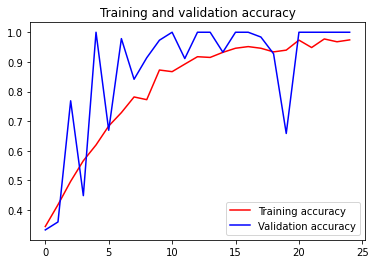

<Figure size 432x288 with 0 Axes>

In [8]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Also we can have a look at the TensorBoard containing more interactive graphs of the data with loading its extension, choosing "Use current working directory" and then selecting the right files in the search bar:

In [ ]:
%load_ext tensorboard

## Hyperparameter Tuning

In the next steps, we will have a look on using hyperparameter tuning in this case.

First we import everything needed.

In [5]:
import keras_tuner as kt

from tensorflow import keras
from tensorflow.keras import layers

from tensorboard import notebook
from tensorboard.plugins.hparams import api as hp

import numpy as np
import datetime


Now we define the function, which creates a model with given hyperparamters. Here we set, in which cases we want to test different parameter.

In our case, we want to test if having a dropout layer is important, how many units in the first Dense layer are better and with which activation choice, and also in compiling the model we will have a look on the impact of changing the RMSprop learning rate as the optimizer parameter.

The rest is like the model we created before, only that it is made in a different way.

In [7]:
def build_model(hp):
    hp_model = tf.keras.Sequential()

    hp_model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)))
    hp_model.add(layers.MaxPooling2D(2,2))
    hp_model.add(layers.Conv2D(64, (3,3), activation='relu'))
    hp_model.add(layers.MaxPooling2D(2,2))
    hp_model.add(layers.Conv2D(128, (3,3), activation='relu'))
    hp_model.add(layers.MaxPooling2D(2,2))
    hp_model.add(layers.Conv2D(128, (3,3), activation='relu'))
    hp_model.add(layers.MaxPooling2D(2,2))
    hp_model.add(layers.Flatten())
    if hp.Boolean("dropout"):
        hp_model.add(layers.Dropout(rate=0.5))
    hp_model.add(
        layers.Dense(
            units = hp.Int("units", min_value=32, max_value=512, step=32),
            activation= hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    hp_model.add(layers.Dense(3, activation='softmax'))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    hp_model.compile(
        loss = 'categorical_crossentropy', 
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), 
        metrics=['accuracy']
    )
    return hp_model

To test if our function returns a valid model:

In [8]:
build_model(kt.HyperParameters())

Now we set up our Keras BayesionOptimization Tuner, which we give our build_model function (having hyperparameters as input), we define that we want to have the highest validation accuracy and we set the number of trials and execution per trial.

In each trial, the machine choses a set of hyperparameter and fits the model over all given epochs.

Also we set here the directory and the project_name for saving all data from each trial which contains all the chosen hyperparameter.

In [11]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory="hp_tmp",
    project_name="04_rps_tuning",
)

With `search_space_summary()` we can have a look at the tuner and all the hyperparameter it will chooses from. In this case, we have 4 different places where different paramters are tested:
- A dropout layer or no dropout layer
- Number of units ranging from 32 to 512
- Choice of two different activations
- Value for learning rate in the range from 0.0001 to 0.01

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dropout (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


With the `search` function the tuner will execute all the trials and outputs each trials set of hyperparameters, the current best set of them and also the normal output like when you fit a model normally.

We will give the function just like a normal model.fit() our training and validation data, set the number of epochs of each trial execution and we also set a TensorBoard instance with a specified logging directory as a callback to visualize each trial, as before.

Now, each trial the with chosen set of hyperparamters it runs a model fit and works with the results with the aim to optimize the choice of the parameters.

In [13]:
log_dir = "hp_tmp/04_tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tuner.search(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[keras.callbacks.TensorBoard(log_dir=log_dir)],
)

Trial 30 Complete [00h 02m 18s]
val_accuracy: 0.8709677457809448

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 48m 41s
INFO:tensorflow:Oracle triggered exit


With `get_best_models` the tuner will return a list of the models with the best val_accuracy, as many as we defined.

We choose the best one and save it as best_model.

In [14]:
hp_models = tuner.get_best_models(num_models=2)
best_model = hp_models[0]

Here, we will have a look at our best model:

In [15]:
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

`results_summary` outputs a summary of the whole search, showing the details of the ten best trials and their sets of parameters.

In [16]:
tuner.results_summary()

Results summary
Results in hp_tmp\04_rps_tuning
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: True
units: 512
activation: relu
lr: 0.00022707875054163085
Score: 1.0
Trial summary
Hyperparameters:
dropout: False
units: 512
activation: tanh
lr: 0.0003557267033472106
Score: 1.0
Trial summary
Hyperparameters:
dropout: False
units: 512
activation: tanh
lr: 0.000364277539789592
Score: 1.0
Trial summary
Hyperparameters:
dropout: False
units: 192
activation: tanh
lr: 0.0004081941231802615
Score: 0.9919354915618896
Trial summary
Hyperparameters:
dropout: False
units: 480
activation: tanh
lr: 0.0005040515782337704
Score: 0.975806474685669
Trial summary
Hyperparameters:
dropout: False
units: 512
activation: tanh
lr: 0.000410636499791608
Score: 0.9731183052062988
Trial summary
Hyperparameters:
dropout: False
units: 512
activation: tanh
lr: 0.00036370497099311866
Score: 0.9704301357269287
Trial summary
Hyperparameters:
dropout: False
units: 288
activation: tanh
lr: 0.00033356091967

With the best hyperparameters which we can derive from the tuner with the method `get_best_hyperparamaters`, we could build a new model with our defined function and show the details of it.

Also we set up the Tensorboard to use in the fit.

In [17]:
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

hp_tensorboard = TensorBoard(log_dir="hp_tmp/logs/{}".format(time()))

best_hps = tuner.get_best_hyperparameters()
model = build_model(best_hps[0])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

Then we could fit the model like normally with using the above defined Tensorboard as a callback.

In [21]:

model.fit(train_generator, epochs=12, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=[hp_tensorboard])

Epoch 1/13
20/20 [==============================] - 29s 1s/step - loss: 0.0669 - accuracy: 0.9766 - val_loss: 0.1417 - val_accuracy: 0.9489
Epoch 2/13
20/20 [==============================] - 29s 1s/step - loss: 0.0588 - accuracy: 0.9798 - val_loss: 0.0823 - val_accuracy: 0.9624
Epoch 3/13
20/20 [==============================] - 28s 1s/step - loss: 0.0602 - accuracy: 0.9798 - val_loss: 0.0501 - val_accuracy: 0.9785
Epoch 4/13
20/20 [==============================] - 28s 1s/step - loss: 0.0512 - accuracy: 0.9806 - val_loss: 0.0614 - val_accuracy: 0.9731
Epoch 5/13
20/20 [==============================] - 28s 1s/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.2415 - val_accuracy: 0.9220
Epoch 6/13
20/20 [==============================] - 28s 1s/step - loss: 0.0565 - accuracy: 0.9794 - val_loss: 0.1405 - val_accuracy: 0.9489
Epoch 7/13
20/20 [==============================] - 28s 1s/step - loss: 0.0500 - accuracy: 0.9837 - val_loss: 0.1649 - val_accuracy: 0.9462
Epoch 8/13
20/20 [==

Also we can save it again as Keras h5 format.

In [26]:
model.save("hp_rps_01.h5")

In the TensorBoard we can have a look at each execution and can explore the impact of the different parameters in the new HPParams tab.

In [ ]:
%load_ext tensorboard

### Load your model

If you want to use a saved model and don't have to run its fit again, insert here the name of the h5-file laying next to this file.

In [6]:
from tensorflow import keras

model = keras.models.load_model("rps.h5")

For test purposes, you can save png-files to test your model with, in the /images directory, and all images are predicted with the following code.

Here you can also see how a png-file has to be prepared so it fits the input requirements of the model.

In [2]:
import numpy as np
from keras.preprocessing import image

imagename_list = os.listdir("images")

for imagename in imagename_list:

    # predicting images
    path = "images/" + imagename
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    prediction = ""
    if classes[0][0] == 1.0:
        prediction = "Paper"
    elif classes[0][1] == 1.0:
        prediction = "Rock"
    elif classes[0][2] == 1.0:
        prediction = "Scissors"
    
    print(imagename + " --> " + prediction + " sein")

scissors01-013.png      müsste  Scissors  sein
test_paper_1.png      müsste  Paper  sein
test_paper_2.PNG      müsste  Paper  sein
test_paper_3.PNG      müsste  Paper  sein
test_paper_4.PNG      müsste  Rock  sein
test_paper_5.PNG      müsste  Scissors  sein
test_rock_1.png      müsste  Rock  sein
test_rock_2.PNG      müsste  Paper  sein
test_rock_3.PNG      müsste  Rock  sein
test_rock_4.PNG      müsste  Scissors  sein
test_scissors_3.PNG      müsste  Scissors  sein
test_sc_1.png      müsste  Scissors  sein
test_sc_2.PNG      müsste  Rock  sein
test_sc_3.PNG      müsste  Scissors  sein
test_sc_4.PNG      müsste  Rock  sein
test_sc_5.PNG      müsste  Rock  sein


## Converting the format of the model

Because our goal is it to make a website and use our model directly in its JavaScript files, we convert our Keras model in a format that ***TensorflowJS*** can use, which is a json-file with shard-files, called the layer format.

Those generated files are used in the next part, the deployment, to let our model work on a website.

In [28]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "models")

# Explainable AI - Usage of SHAP

With Shap (SHapely Additive exPlanations) we can explain the output of our machine learning model.

First, we have to convert our data to a datatype SHAP can use (numpy.ndarray) and split each the train and validation data into X and y for further steps.

In [32]:
print(type(train_generator))
train_x, train_y = train_generator.next()
val_x, val_y = validation_generator.next()
print(type(train_x))

<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
<class 'numpy.ndarray'>


For the following we are going to need shap and numpy.

In [33]:
import shap
import numpy as np

We are using the `DeepExplainer` which needs the model and a background which we create beforehand.

We use this Explainer to generate the SHAP values and plot these below.
The blue areas show negative SHAP values whereas the red ones show positive SHAP values. 

Each column stands for one class (Paper, Rock, Scissors) and explains how the model decides which class an image is predicted to be.

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


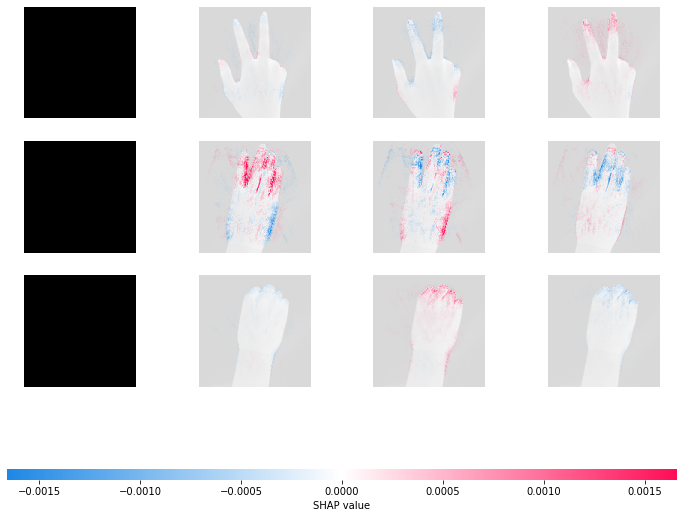

In [68]:
background = train_x[np.random.choice(train_x.shape[0],100, replace=False)]

explainer = shap.DeepExplainer(model, background)

shap_values = explainer.shap_values(val_x[0:3])

shap.image_plot(shap_values, -val_x[0:3])